<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product " />
</a> 

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/cc-logo-square.png" width="200" alt="cognitiveclass.ai logo" />

<h1>Linear  Classifier with PyTorch </h1>

<p>Before you use a  Deep neural network to solve the classification problem,  it 's a good idea to try and solve the problem with the simplest method. You will need the dataset object from the previous section.
In this lab, we solve the problem with a linear classifier.
 You will be asked to determine the maximum accuracy your linear classifier can achieve on the validation data for 5 epochs. We will give some free parameter values if you follow the instructions you will be able to answer the quiz. Just like the other labs there are several steps, but in this lab you will only be quizzed on the final result. </p>

<h2>Table of Contents</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">


<ul>
    <li><a href="#download_data"> Download data</a></li>
    <li><a href="#auxiliary"> Imports and Auxiliary Functions </a></li>
    <li><a href="#data_class"> Dataset Class</a></li>
    <li><a href="#trasform_Data_object">Transform Object and Dataset Object</a></li>
    <li><a href="#Question">Question</a></li>
</ul>
<p>Estimated Time Needed: <strong>25 min</strong></p>
 </div>
<hr>


<h2 id="download_data">Download Data</h2>

In this section, you are going to download the data from IBM object storage using <b>wget</b>, then unzip them.  <b>wget</b> is a command the retrieves content from web servers, in this case its a zip file. Locally we store the data in the directory  <b>/resources/data</b> . The <b>-p</b> creates the entire directory tree up to the given directory.

First, we download the file that contains the images, if you dint do this in your first lab uncomment:

In [7]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip -P /resources/data

--2020-07-23 16:16:30--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245259777 (234M) [application/zip]
Saving to: ‘/resources/data/concrete_crack_images_for_classification.zip’

concrete_crack_imag 100%[===================>] 233.90M  20.1MB/s    in 11s     

2020-07-23 16:16:41 (21.9 MB/s) - ‘/resources/data/concrete_crack_images_for_classification.zip’ saved [245259777/245259777]



We then unzip the file, this ma take a while:

In [8]:
!unzip -q  /resources/data/concrete_crack_images_for_classification.zip -d  /resources/data

We then download the files that contain the negative images:

<h2 id="auxiliary">Imports and Auxiliary Functions</h2>

The following are the libraries we are going to use for this lab:

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
from torch import optim 

<h2 id="data_class">Dataset Class</h2>

In this section, we will use the previous code to build a dataset class. As before, make sure the even samples are positive, and the odd samples are negative.  If the parameter <code>train</code> is set to <code>True</code>, use the first 30 000  samples as training data; otherwise, the remaining samples will be used as validation data. Do not forget to sort your files so they are in the same order.  

In [3]:
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/resources/data"
        positive="Positive"
        negative="Negative"

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
        positive_files.sort()
        negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
        negative_files.sort()
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)    
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        
        
        image=Image.open(self.all_files[idx])
        y=self.Y[idx]
          
        
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

<h2 id="trasform_Data_object">Transform Object and Dataset Object</h2>

Create a transform object, that uses the <code>Compose</code> function. First use the transform <code>ToTensor()</code> and followed by <code>Normalize(mean, std)</code>. The value for <code> mean</code> and <code>std</code> are provided for you.

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# transforms.ToTensor()
#transforms.Normalize(mean, std)
#transforms.Compose([])

transform =transforms.Compose([ transforms.ToTensor(), transforms.Normalize(mean, std)])


Create object for the training data  <code>dataset_train</code> and validation <code>dataset_val</code>. Use the transform object to convert the images to tensors using the transform object:

In [5]:
dataset_train=Dataset(transform=transform,train=True)
dataset_val=Dataset(transform=transform,train=False)

We  can find the shape of the image:

In [6]:
dataset_train[0][0].shape

torch.Size([3, 227, 227])

We see that it's a color image with three channels:

In [7]:
size_of_image=3*227*227
size_of_image

154587

<h2 id="Question"> Question <h2>

<b> Create a custom module for Softmax for two classes,called model. The input size should be the <code>size_of_image</code>, you should record the maximum accuracy achieved on the validation data for the different epochs. For example if the 5 epochs the accuracy was 0.5, 0.2, 0.64,0.77, 0.66 you would select 0.77.</b>

Train the model with the following free parameter values:

<b>Parameter Values</b>
   <li>learning rate:0.1 </li>
   <li>momentum term:0.1 </li>
   <li>batch size training:1000</li>
   <li>Loss function:Cross Entropy Loss </li>
   <li>epochs:5</li>
   <li>set: torch.manual_seed(0)</li>

In [47]:
learning_rate = 0.1
mome = 0.1
batch_size = 1000
n_epochs = 5
size_of_output = 2

In [30]:
torch.manual_seed(0)

In [31]:
dataset_train.len

30000

<b>Custom Module:</b>

In [32]:
class SoftMax(nn.Module):
  def __init__(self, in_size, out_size):
    super(SoftMax, self).__init__()
    self.linear = nn.Linear(in_size, size_of_output)

  def forward(self, x):
    out = self.linear(x)
    return out

<b>Model Object:</b>

In [33]:
model = SoftMax(size_of_image, size_of_output)

In [34]:
print('W: ',list(model.parameters())[0].size())
print('b: ',list(model.parameters())[1].size())

W:  torch.Size([2, 154587])
b:  torch.Size([2])


<b>Optimizer:</b>

In [35]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=mome)

<b>Criterion:</b>

In [37]:
criterion = nn.CrossEntropyLoss()

<b>Data Loader Training and Validation:</b>

In [18]:
data_loader_train = DataLoader(dataset_train, batch_size=batch_size)
data_loader_val = DataLoader(dataset_val, batch_size=batch_size)

<b>Train Model with 5 epochs, should take 35 minutes: </b>

In [51]:
loss_list = []
accuracy_list = []
num_val = len(dataset_val)

def train_model(n_epochs):
  for epoch in range(n_epochs):
    for X, y in data_loader_train:
      # set gradient to 0
      optimizer.zero_grad()
      # feed forward
      output = model(X.view(-1, size_of_image))
      # Loss calculation
      loss = criterion(output, y)
      # Gradient calculation
      loss.backward()
      # Model weight modification based on the optimizer. 
      optimizer.step()

    correct = 0
    for X_val, y_val in data_loader_val:
      output_val = model(X_val.view(-1, size_of_image))
      _, y_val_hat = torch.max(output_val.data, 1)
      correct += (y_val_hat == y_val).sum().item()
      
    accuracy = correct / num_val
    print("Epoch: {}. Accuracy: {}.".format(epoch, accuracy))
    loss_list.append(loss.data)
      
    accuracy_list.append(accuracy)

In [52]:
train_model(n_epochs)

Epoch: 0. Accuracy: 0.567.
Epoch: 1. Accuracy: 0.7608.
Epoch: 2. Accuracy: 0.756.
Epoch: 3. Accuracy: 0.7453.
Epoch: 4. Accuracy: 0.5755.


In [53]:
accuracy_list

[0.567, 0.7608, 0.756, 0.7453, 0.5755]

In [54]:
loss_list

[tensor(1522.7980),
 tensor(2828.7859),
 tensor(2830.5500),
 tensor(3164.7698),
 tensor(1204.3848)]

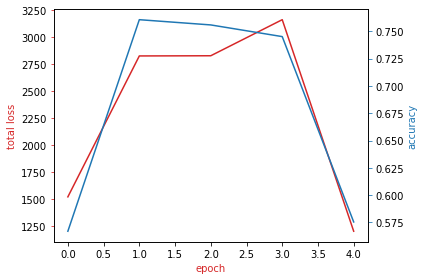

In [55]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)


ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

fig.savefig('accuracy.png', dpi=300)

<h2>About the Authors:</h2>
 <a href=\"https://www.linkedin.com/in/joseph-s-50398b136/\">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

Copyright &copy; 2019 <a href="cognitiveclass.ai"> cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>